# Ejemplo de simulacion en el centro historico

In [1]:
import numpy as np
import math
import networkx as nx
import pandas as pd
from tqdm import tqdm
import time
import pickle
import random
import colorsys
from matplotlib.ticker import MaxNLocator
from collections import Counter
import matplotlib.colors as mcolors
import os
import pickle
import copy
from scipy.spatial.distance import pdist, squareform
import gc
import matplotlib.pyplot as plt

In [2]:
# cargar el modelo
import simulation_model
from simulation_model import Modelo

## Cargar centro historico

In [3]:
# carpeta donde se tiene la informacion del grafo
carpeta_datos = ".\\Datos_centro_historico\\"

In [4]:
# cargar el grafo del centro
with open(carpeta_datos + 'ejesviales_centro_graph.gpickle', 'rb') as f:
    G_centro = pickle.load(f)

print(f"Grafo del centro historico")
print(f"Numero de nodos:   {G_centro.number_of_nodes()}")
print(f"Numero de aristas: {G_centro.number_of_edges()}")

Grafo del centro historico
Numero de nodos:   18872
Numero de aristas: 20352


In [5]:
# cargar el pos
with open(carpeta_datos + 'ejesviales_centro_pos.pickle', 'rb') as f:
    pos_centro = pickle.load(f)

# ver que tenga de los nodos
print(f"Pos para {len(pos_centro)} nodos")

Pos para 18872 nodos


In [6]:
# definir probabilidades de origen
# primero se encuentra el posicion central
array_pos = np.array(list(pos_centro.values()))
pos_central = array_pos.mean(axis = 0)

# indetificar nodos con poca probabilidad de origen
# para compensar su distancia larga al centro
# esto es poruqe no esta totalmente centrado
subgrafo = nx.ego_graph(G_centro, 10072, radius=250, undirected=True)
nodos_casi_no_origen = list(subgrafo.nodes())

# ahora por cada nodo calcular la distancia de su pos al pos central
# guardar en un dict
distancias_centro = {}
for nodo in G_centro.nodes():
  # solo hacer si tiene grado menor a 3
  if G_centro.degree(nodo) < 3:
    # si es de los nodos con poca probabilidad de origen
    if nodo in nodos_casi_no_origen:
      # pues menor probabilidad
      distancias_centro[nodo] = np.linalg.norm(np.array(pos_centro[nodo]) - pos_central)/10
    else:
      # de los normales
      distancias_centro[nodo] = np.linalg.norm(np.array(pos_centro[nodo]) - pos_central)
  # sino, hacerlo 0
  else:
    distancias_centro[nodo] = 0

# normalizar para tener probabilidades
suma_distancias = sum(distancias_centro.values())
proba_origen_centro = {nodo : distancias_centro[nodo]/suma_distancias for nodo in G_centro.nodes()}

del distancias_centro

In [7]:
# cargar las probabilidades de destino
with open(carpeta_datos + 'proba_destino.pkl', 'rb') as f:
    proba_destino_centro = pickle.load(f)

# remplazar Nan con 0
proba_destino_centro = {k: (v if pd.notna(v) else 0) for k, v in proba_destino_centro.items()}

In [8]:
# poner todo esto en un dict
info_grafo_centro = {
    "G": G_centro,
    "pos": pos_centro,
    "proba_origen": proba_origen_centro,
    "proba_destino": proba_destino_centro
}

In [9]:
# argumentos de visualizacion
arg_visua_centro = {
    "node_size": 0.1,
    "edge_color": "gray",
    "arrowsize": 0.1,
    "color_vacio": '#f0f0f0',
    "color_bloqueo": "red",
    "color_atasco": "red"
}

## Ejecutar el modelo de simulacion

In [10]:
# bloqueos del modelo
bloqueos_centro = []

In [11]:
# obtener el numero de steps y la funcion lambda para que tenga sentido temporal
total_steps, funcion_lambda = simulation_model.get_total_steps_and_lambda_function(HORA_INICIAL = 7,
                                                                                   HORA_FINAL = 10,
                                                                                   NUM_AGENTES_TOTALES = 400,
                                                                                   STEPS_PER_HORA = 100)

In [12]:
# crear
model_centro = Modelo(info_grafo_centro, argumentos_visualizacion = arg_visua_centro)
# correr
model_centro.run_model(poblacion_inicial = 1200,
                      lambda_tiempo = funcion_lambda,
                      steps_generando = total_steps, steps_finales = 0,
                      visualizar= False, sleep= 0.001,
                      ver_barra_progreso = True,
                      pesos_trafico = "simple",
                      tiempo_recalcular_agentes = 10,
                      bloqueos = bloqueos_centro)

Tiempos minimos:: 100%|███████████████████████████████████████████████████████████| 1594/1594 [00:04<00:00, 381.88it/s]


In [13]:
# salvar los resultados (para visualizarlos despues)
model_centro.salvar_modelo(folder_path = "./Info simulacion centro/")

## Visualizar resultados

In [14]:
# obtener df con info
results = model_centro.datacollector.get_model_vars_dataframe()
results.head()

,Numero de agentes,Agentes esperando
0,1200,0
1,1204,60
2,1184,41
3,1172,44
4,1166,37


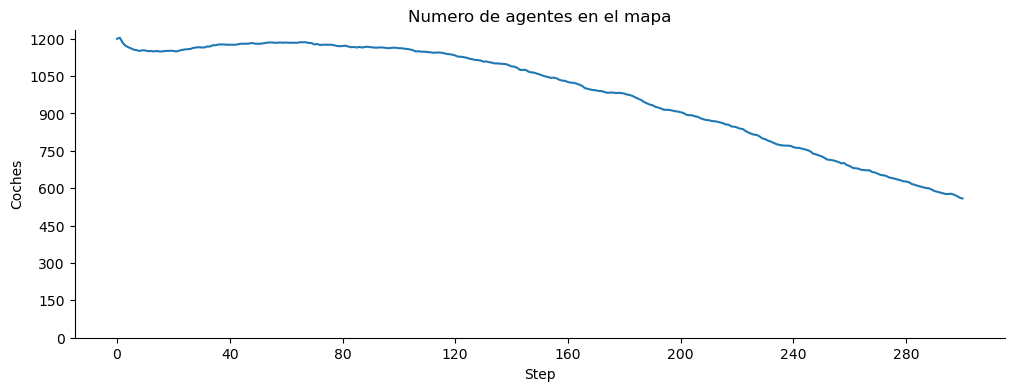

In [15]:
# ver numero de agentes en el mapa
fig, ax = plt.subplots(figsize=(12, 4))
model_centro.mostrar_agentes_presentes(ax=ax)
plt.show()

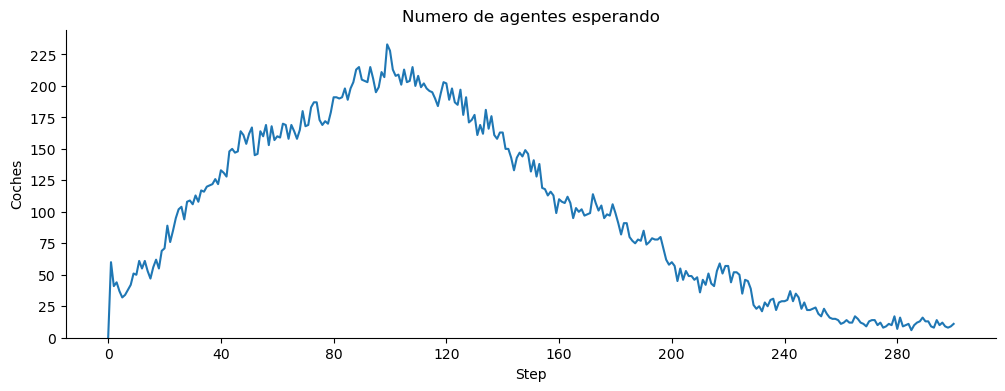

In [16]:
# ver numero de agentes esperando en cada momento
fig, ax = plt.subplots(figsize=(12, 4))
model_centro.mostrar_agentes_esperando(ax=ax)
plt.show()

In [17]:
# diccionario con todos los agentes creados
numero_agentes = len(model_centro.historico_agentes)
print(f"Se crearon {numero_agentes} agentes")

Se crearon 1594 agentes


In [18]:
# ver info
model_centro.imprimir_estadisticas_tiempos_agentes()

Informacion de los 1035 agentes que llegaron a su destino
Tiempo minimo promedio: 141.577
Tiempo real promedio: 157.564
Porcentaje promedio de retraso: 10.151%
Promedio de veces que un agente recalcula: 8.224
Porcentaje promedio de recálculos inútiles: 80.128%


In [24]:
# tomar un agente arbitrario
agent = model_centro.historico_agentes[1223]

# ver info
print(f"El agente aparece en el step: {agent.step_creation}")
print(f"Tiempo minimo que toma su recorrido: {agent.tiempo_minimo:.3f}")
print(f"Tiempo que tomó al hacer el recorrido: {agent.tiempo_real:.3f}")
print(f"Porcentaje de retraso: {(100 * agent.tiempo_real / agent.tiempo_minimo - 100):.3f}%")
print(f"Número de veces que recalcula su camino: {agent.num_recalculadas}")
if agent.num_recalculadas != 0:
    print(f"Porcenaje de recalculos inutiles: {(100*agent.num_recalculadas_inutiles/ agent.num_recalculadas):.3f}%")

El agente aparece en el step: 10
Tiempo minimo que toma su recorrido: 174.000
Tiempo que tomó al hacer el recorrido: 288.000
Porcentaje de retraso: 65.517%
Número de veces que recalcula su camino: 12
Porcenaje de recalculos inutiles: 91.667%


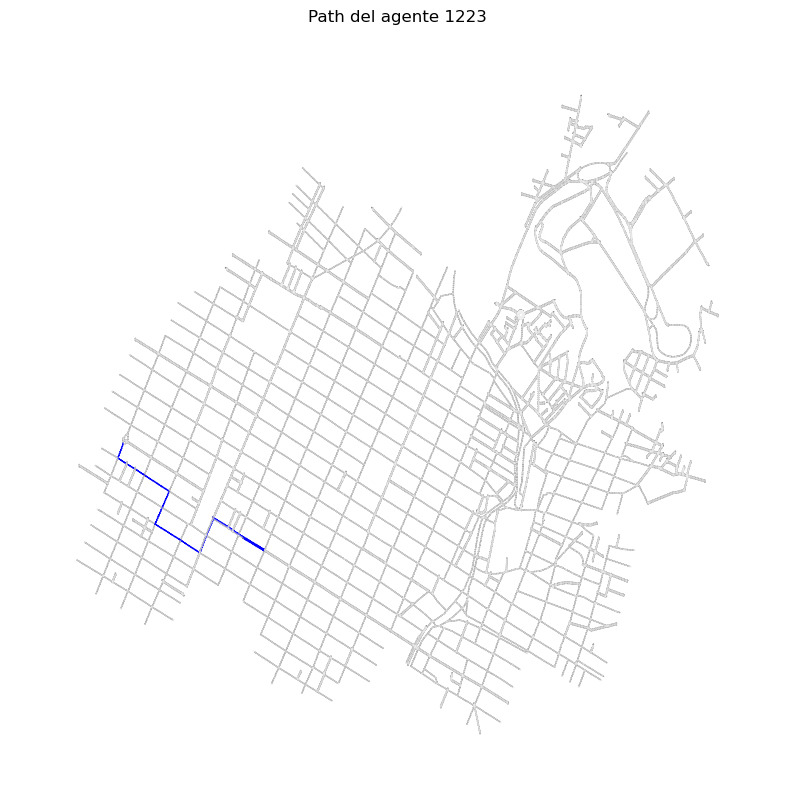

In [25]:
# graficar el path de agentes
idx_agente = 1223
fig, ax  = plt.subplots(figsize=(10, 10))
model_centro.dibujar_path(model_centro.historico_agentes[idx_agente].path, ax=ax, color_path = "blue", alpha_min = 0.3)
ax.set_title(f"Path del agente {idx_agente}")
plt.show()

In [26]:
# ver centralidades de los nodos
df_centr_nodos, df_centr_edges = model_centro.obtener_centralidades_df()

In [27]:
# centralidades de nodos
df_centr_nodos.head()

,node,centralidad
9813,10312,174
226,6694,173
13984,16592,173
9815,123,173
13981,16228,172


In [28]:
# centralidades de aristas
df_centr_edges.head()

,edges,centralidad
274,"(6694, 10422)",120
9135,"(10422, 2547)",119
5072,"(2547, 5667)",117
5075,"(6013, 6162)",116
5074,"(5667, 6013)",116


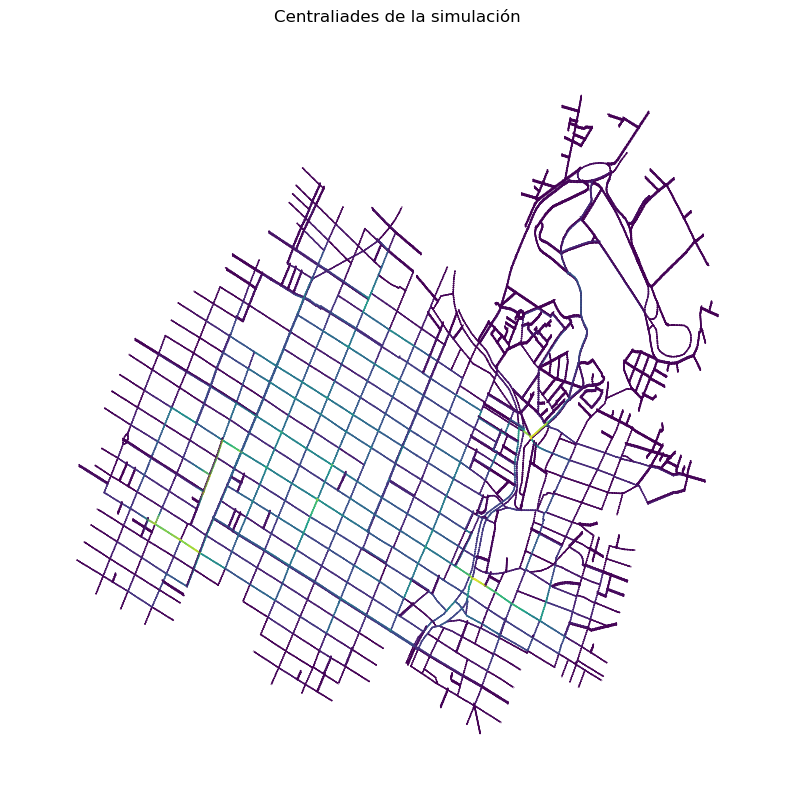

In [29]:
# visualizarlas
fig, ax  = plt.subplots(figsize=(10, 10))
model_centro.dibujar_centralidades(ax=ax)
ax.set_title("Centraliades de la simulación")
plt.show()

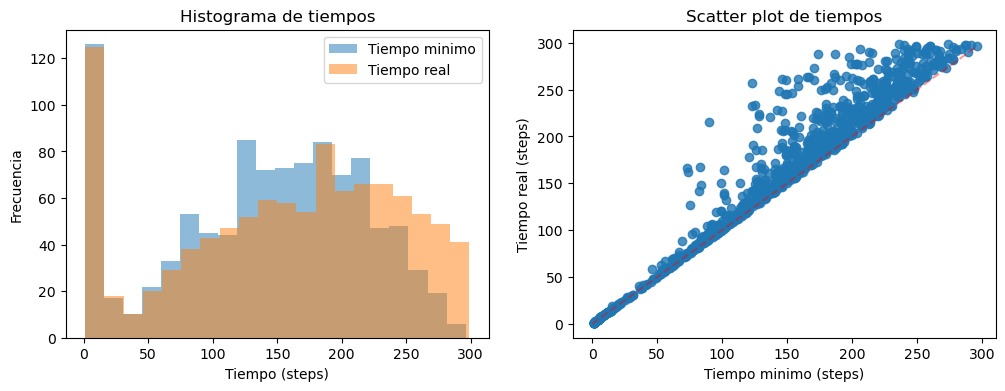

In [30]:
# ver los tiempos reales y optimos de los agentes
model_centro.graficar_tiempos_agentes(alpha_hist = 0.5, alpha_scatter = 0.8)

In [21]:
# ver los nodos con mayor atasco
model_centro.get_atascos_agentes(min_espera=30).head()

,nodo,tiempo,agente
12,2877,40,1223
2,3216,39,91
0,1782,39,36
4,13164,39,374
3,2102,39,237


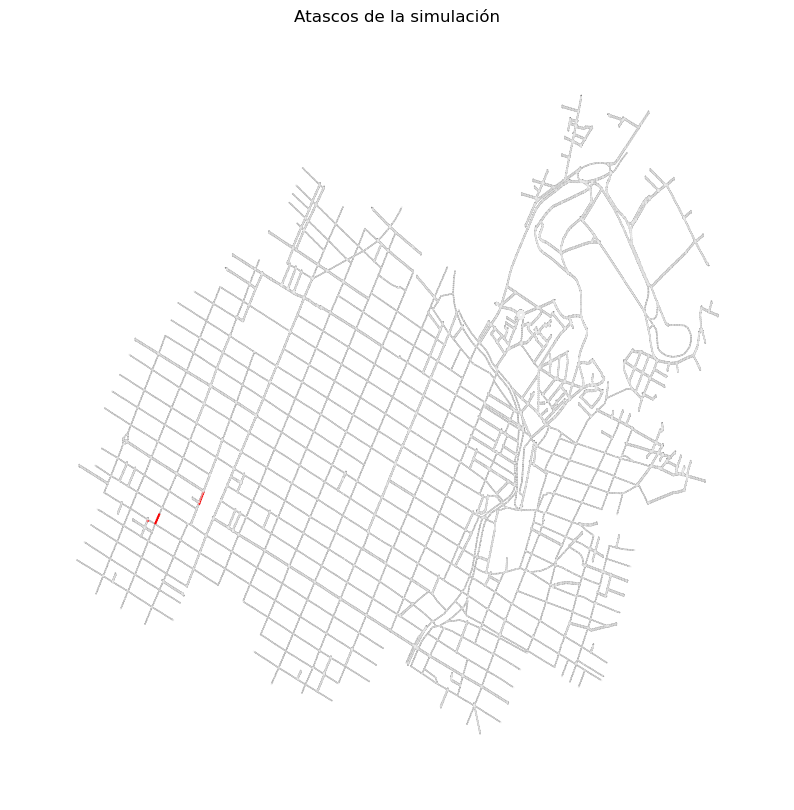

In [31]:
# visualizar los nodos de atascos
fig, ax  = plt.subplots(figsize=(10, 10))
model_centro.ver_atascos_agentes(min_espera = 30, ax=ax)
ax.set_title("Atascos de la simulación")
plt.show()